In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
plt.style.use('fivethirtyeight')

# Waiting for the bus

When you are exploring a city, the public transportation is an awesome way to support civil infrastructure and reduce greenhouse gas emissions. One frustrating part about buses and trains is the act of waiting. When you look at the schedule, it may report that buses come every 60 min, so on average you should be waiting 30 minutes each time you arrive at a bus stop. **But** it feels like every time you get to the bus stop you are waiting on the one bus that is 20 minutes late. Is it just your bad luck? or is there something else happening here?

Let's set up a Monte Carlo experiment. 

## Buses come every hour

First, we'll set up buses to come at hour 0 and plan for every hour another bus comes. So time just continues increasing, 

|bus | scheduled time (hours) |
|---|---|
|1 | 1.0|
|2 | 2.0|
|...|...|
|N | N |

In [2]:
N_buses = 1000

bus_arrival = np.arange(1, N_buses+1)*1.0

## Add some randomness

Each bus is scheduled to arrive on the hour, but there could be traffic, different numbers of passengers, etc. All leading to some change in the arrival time. Here, we add a random amount of time to each scheduled arrival to simulate the _actual arrival_.

|bus | scheduled time (hours) | arrival (hours)|
|---|---|---|
|1 | 1.0|1.05
|2 | 2.0|1.83
|...|...|...|
|N | N | $N+\Delta t$|

Next, we'll look at the histogram of differences between bus arrivals as a histogram. As we expect, the average time between buses is 60 min (1 hour) with as little as 20 min and as much as 100 min. 

Text(0.5, 0, 'time between buses (min)')

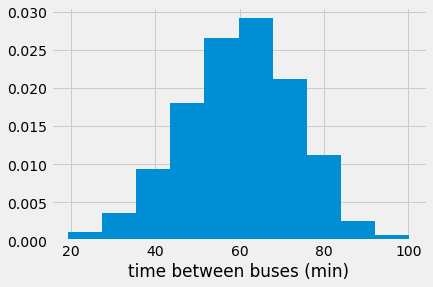

In [3]:
rng = default_rng(42)
bus_arrival += rng.normal(loc = 0, scale = 1/6, size = N_buses)

plt.hist(np.diff(bus_arrival)*60, density=True)
plt.xlabel('time between buses (min)')

## Time to make a prediction

If we have 500 people are going to get on these 1000 buses, how many people will get on the buses that came:

- less than 60 min after the previous bus (avg wait time)
- less than 20 min after the previous bus (min wait time)
- less than 100 min after the previous bus (max wait time)


We can make a [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) to look at the relative number of buses that arrived in a given interval. Looking at the graph below, 100% of buses arrived before 100 min and 50% of buses arrived before 60 min. 

My prediction could now be:

- 1% of the people will get on a bus with a <20 min wait
- 50% of the people will get on buses with <60 min wait
- 100% of people will get on buses with <100 min wait

or, I can use intervals to interpret the data

- 50% of the people will get on buses with 50-70 min intervals
- 25% of people will get on buses with 70-100 min intervals
- 25% of people will get on huses with 20-50 min intervals


Text(0.5, 0, 'minutes between buses')

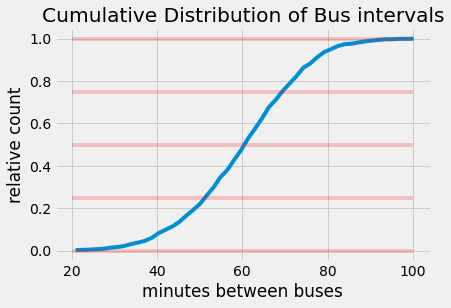

In [4]:
bus_time_diff = np.diff(bus_arrival)*60

count, bins_count = np.histogram(bus_time_diff, bins=50)
pdf = count / sum(count)
cdf = np.cumsum(pdf) 
plt.plot(bins_count[1:], cdf)
plt.hlines([0, 0.25, 0.5, 0.75, 1], 
           20, 
           100, 
          alpha = 0.2, 
          colors = 'r')
plt.title('Cumulative Distribution of Bus intervals')
plt.ylabel('relative count')
plt.xlabel('minutes between buses')

## Test our prediction

We have 1000 buses, so lets assume 5 people are trying to get on at our stop. They will show up some time during the 1000 hours to catch the next bus. We generate 5000 arrival times for people from 0 to 999 hours. 

> _Note: we can think of this as a continuously running bus station so hour 300 would be 300/24 = 12 days and 12 hours into our experiment. Monte Carlo results keep improving with repeated sampling, so more buses + more people = better results._



In [5]:
num_people = 500
people_arrival = rng.random(num_people)*N_buses

Now, we can see how many people would get on bus #1 and find the interval between bus 1 and bus 2. 

In [6]:
print('{} people arrived for bus #1 in the {:1.1f} min interval'.format(np.size(people_arrival[people_arrival< bus_arrival[0]]),
(bus_arrival[1] - bus_arrival[0])*60))

1 people arrived for bus #1 in the 46.6 min interval


### Possible issue with our prediction

Already we're starting to see an issue. Why is there only 1-out-of-5000 people that arrived before the 46.6 min mark? Shouldn't we see 10-15% of our 5000 passengers in <46.6 min intervals?

Let's push forward and find how many people are on _every_ bus, we're going to create a variable to find the interval between buses and how many people were on that bus. Next, we can sort the results from smallest interval to largest and cumulatively sum the number of people that were on the buses (for our cumulative distribution function), 

`obs_bus_interval`:

|bus interval (min)|# of people on bus|
|---|---|
|46.6 | 1 |
|...|...|

In [7]:
person_wait = np.zeros(len(people_arrival))
obs_bus_interval = np.zeros((len(bus_arrival), 2))
for i, bus_time in enumerate(bus_arrival[:-1]):
    people_on_bus = np.size(people_arrival[
        np.logical_and(people_arrival>=bus_time,
                       people_arrival<bus_arrival[i+1])])
    obs_bus_interval[i, 0] = bus_arrival[i+1] - bus_time
    obs_bus_interval[i, 1] = people_on_bus

In [8]:
obs_bus_interval = obs_bus_interval[obs_bus_interval[:, 0].argsort()]

Text(0.5, 0, 'minutes between buses')

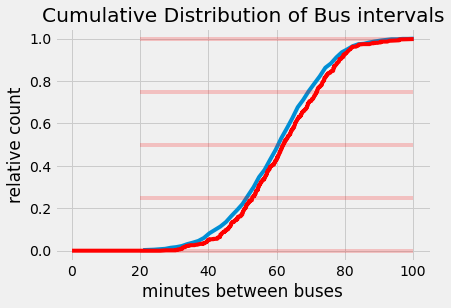

In [9]:
plt.plot(bins_count[1:], 
         cdf,
         label = 'CDF measured'
        )

cdf_obs = np.cumsum(obs_bus_interval[:, 1])/num_people

plt.plot(obs_bus_interval[:, 0]*60, 
         cdf_obs, 
         'r-',
        label = 'CDF observed')

plt.hlines([0, 0.25, 0.5, 0.75, 1], 
           20, 
           100, 
          alpha = 0.2, 
          colors = 'r')
plt.title('Cumulative Distribution of Bus intervals')
plt.ylabel('relative count')
plt.xlabel('minutes between buses')

### Why is everyone waiting so long?

Our CDF is shifted to longer wait times. Now, we see 50% of our passengers are waiting on buses <65 min and 25% of our passengers are waiting <53 min. What happened?

Allen Downey calls this the [Inspection Paradox](https://allendowney.blogspot.com/2015/08/the-inspection-paradox-is-everywhere.html). Because people show up at random times, we are reducing the chance that someone can catch a bus if the interval is only 20-40 min, but buses with 100 min intervals have a higher chance of people arriving. 